# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from datetime import datetime

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Data load and Pre-processing

In [2]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')

/home/sumit/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


It appears there is data of mixed types in these two columns and pandas could not convert successfully and saved them as objects instead. We will look at these later. First, let's verify the data against the spreadsheet provided with valid values ('DIAS Attributes - Values 2017.xlsx'). 

In [3]:
mix_type_columns = azdias.columns[[18,19]]
print(mix_type_columns)
print(azdias.shape)
azdias.head(n=5)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Let's load the spreadsheet
azdias_features = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, usecols="B:E")
azdias_features.head(n=5)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [5]:
# We can use forward fill to update Attribute and Description columns
azdias_features = azdias_features.fillna(method='ffill')

# Let's find all attribute values that have valid values i.e. ignore Unknowns 
azdias_features = azdias_features[~(azdias_features.Meaning.str.contains('no ') | azdias_features.Meaning.str.contains('unknown'))]

azdias_features.head()

,Attribute,Description,Value,Meaning
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years


In [6]:
# Create a dataframe with valid values for the features available in the spreadsheet ('DIAS Attributes - Values 2017.xlsx')
azdias_valid_feature_values = pd.DataFrame()
for feature in azdias_features.Attribute.unique():
    values = list(azdias_features[azdias_features.Attribute==feature]['Value'])
    azdias_valid_feature_values = azdias_valid_feature_values.append(pd.DataFrame([[feature, values]]), ignore_index = True)

azdias_valid_feature_values.columns = ['Attribute', 'Values']    

# There are some features without a fixed range of values in the spreadsheet. Lets look at those
numeric_features_per_spreadsheet = azdias_features[azdias_features.Meaning.str.contains('numeric value')]
numeric_features_per_spreadsheet

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,…,numeric value


In [7]:
#Lets update Value to a appropriate range in azdias_valid_feature_values dataframe for these features
a = [list(range(1,11))]
b = [list(range(1,4))]
year = [list(range(1900, 2020))]
cars_num = [list(range(0,4000))]

# Columns that typically have a value between 1 and 10
for col in ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_TITEL']:
    azdias_valid_feature_values.loc[azdias_valid_feature_values.Attribute == col, 'Values'] = pd.Series(a, index = np.where(azdias_valid_feature_values.Attribute == col)[0])

# Columns that typically have a value between 1 and 3
azdias_valid_feature_values.loc[azdias_valid_feature_values.Attribute == 'ANZ_PERSONEN', 'Values'] = pd.Series(b, index = np.where(azdias_valid_feature_values.Attribute == 'ANZ_PERSONEN')[0])

# Columns that have year as value
for col in ['GEBURTSJAHR', 'MIN_GEBAEUDEJAHR']:
    azdias_valid_feature_values.loc[azdias_valid_feature_values.Attribute == col, 'Values'] = pd.Series(year, index = np.where(azdias_valid_feature_values.Attribute == col)[0])
    
# Column that has number of cars as value. Current max is 2300. Using a range 0-4000 for the sake of similicity for now.
azdias_valid_feature_values.loc[azdias_valid_feature_values.Attribute == 'KBA13_ANZAHL_PKW', 'Values'] = pd.Series(cars_num, index = np.where(azdias_valid_feature_values.Attribute == 'KBA13_ANZAHL_PKW')[0])    

In [8]:
# Columns that are common in 'DIAS Attributes - Values 2017.xlsx' spreadsheet and azdias dataframe
def get_common_columns():
    '''
    This function returns a list of columns are present in 'DIAS Attributes - Values 2017.xlsx' and also in azdias dataset
    
    Input: None
    
    Output: List of column names
    '''
    return set(azdias.columns).intersection(set(azdias_valid_feature_values.Attribute))

common_columns = get_common_columns()

In [9]:
# Update values to NaNs in azdias dataframe if the values are outside of the range as defined in azdias_valid_feature_values
for col in common_columns:
    valid_values = azdias_valid_feature_values.loc[azdias_valid_feature_values.Attribute==col, 'Values'].iloc[0]
    invalid_values_idx = ~azdias.loc[:,col].isin(valid_values)
    azdias.loc[invalid_values_idx,col] = np.nan

In [10]:
def get_non_numeric_data_rows(series):
    '''
    This function takes in a Pandas series as input and returns the row indices containing non numeric data    
    
    Input: Pandas Series
    
    Output: A list containing indices for non-numeric data
    '''
    rows_with_nonnumeric_data = []

    for index, value in series[series.notnull()].items():
        try:
            int(value)
        except:
            rows_with_nonnumeric_data.append(index)
            
    return rows_with_nonnumeric_data

In [11]:
# Let's take care of the columns that caused mix type warning during load
# CAMEO_INTL_2015
rows_with_nonnumeric_data = get_non_numeric_data_rows(azdias.CAMEO_INTL_2015)
azdias.CAMEO_INTL_2015[rows_with_nonnumeric_data].value_counts()      

XX    373
Name: CAMEO_INTL_2015, dtype: int64

In [12]:
# Check different values of CAMEO_INTL_2015 feature. This feature is not present in the spreadsheet ('DIAS Attributes - Values 2017.xlsx')
azdias.CAMEO_INTL_2015.value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

We can see that the majority of the rows have a numeric value. We will convert these XX to NaNs and use an Imputer later. XX don't appear to be a valid value for this feature

In [13]:
#Updating 'XX' to Nan
azdias.loc[azdias.CAMEO_INTL_2015=='XX', 'CAMEO_INTL_2015'] = np.NaN

# Now converting to numeric type
azdias.CAMEO_INTL_2015 = azdias.CAMEO_INTL_2015.astype('float')

In [14]:
# CAMEO_DEUG_2015

# We do not have to worry about this feature since it was present in the spreadsheet. All invalid values got updated to NaNs in the code above

In [15]:
# Percentage of rows that have missing values for each of the columns.
missing_features = round((azdias.isnull().sum(axis=0)/azdias.shape[0])*100, 2).sort_values(ascending=False)

Text(0, 0.5, 'Percentage of NaN')

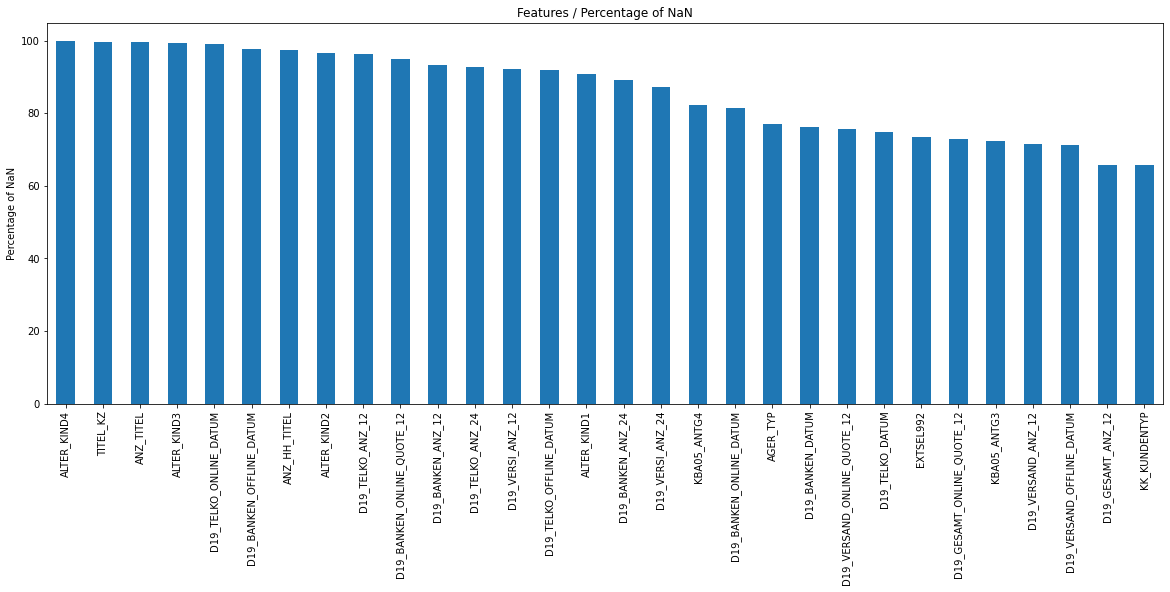

In [16]:
# Lets plot some of features with highest missing data percentage
plt.figure(figsize=(20,7))
missing_features[0:30].plot.bar();
plt.title('Features / Percentage of NaN')
plt.ylabel('Percentage of NaN')

Wow, we have some features where 99% of the values are missing. Let's drop the columns with 50% or more missing values. These features won't help us much in analysis or modeling.

In [17]:
columns_to_drop_due_to_missing_data = list(missing_features[missing_features >= 50].index)
print('Dropping following features \n {}' .format(columns_to_drop_due_to_missing_data))
azdias = azdias.drop(columns_to_drop_due_to_missing_data, axis=1)
print("New dimension of azdias: {}" .format(azdias.shape))

Dropping following features 
 ['ALTER_KIND4', 'TITEL_KZ', 'ANZ_TITEL', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'ANZ_HH_TITEL', 'ALTER_KIND2', 'D19_TELKO_ANZ_12', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_TELKO_OFFLINE_DATUM', 'ALTER_KIND1', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24', 'KBA05_ANTG4', 'D19_BANKEN_ONLINE_DATUM', 'AGER_TYP', 'D19_BANKEN_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_TELKO_DATUM', 'EXTSEL992', 'D19_GESAMT_ONLINE_QUOTE_12', 'KBA05_ANTG3', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 'D19_VERSAND_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'CAMEO_DEUG_2015', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ONLINE_DATUM', 'KBA05_BAUMAX', 'D19_GESAMT_ONLINE_DATUM']
New dimension of azdias: (891221, 329)


In [18]:
# Delete all rows where more than 100 features have values missing
rows_to_keep = azdias.isnull().sum(axis=1) < 100
azdias = azdias[rows_to_keep]
print(azdias.shape)
azdias.head()

(785410, 329)


,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,NaN,21.0,NaN,0.0,2.0,12.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,9.0,17.0,17.0,10.0,0.0,1.0,7.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,1.0,13.0,13.0,1.0,0.0,NaN,2.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,1.0,20.0,14.0,3.0,0.0,NaN,3.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,910244,1.0,10.0,10.0,5.0,0.0,1.0,2.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


In [19]:
#Lets check object type features in azdias dataframe
azdias.select_dtypes(include='object')

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,D19_ENERGIE,1992-02-12 00:00:00,W
...,...,...,...,...
891216,7A,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [20]:
# function to Convert EINGEFUEGT_AM to number of seconds since unix epoch start
def convert_datetime_to_seconds(x):
    '''
    This function converts datetime stored as strings to number of seconds since unix epoch
    
    Input: string
    
    Output: number of seconds since epoch as int
    '''
    try:
        return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()
    except:
        # for cases where x is not a valid datetime
        return 0
    

In [21]:
# Convert EINGEFUEGT_AM to number of seconds
azdias.EINGEFUEGT_AM = azdias.EINGEFUEGT_AM.apply(convert_datetime_to_seconds)

In [22]:
cols_not_in_spreadsheet = list(set(azdias.columns).difference(set(azdias_valid_feature_values.Attribute)))
for col in cols_not_in_spreadsheet:
    print(azdias[col].dtype)

float64
float64
float64
float64
float64
float64
float64
int64
float64
float64
float64
int64
int64
int64
float64
int64
int64
int64
int64
float64
float64
float64
float64
int64
float64
float64
float64
float64
int64
float64
float64
float64
int64
int64
float64
float64
float64
int64
float64
int64
int64
int64
float64
int64
float64
object
float64
int64
float64
int64
int64
float64
float64
int64
float64
float64
float64
int64
int64
int64
float64
float64
float64
int64
int64
float64
float64
float64
int64
int64
int64
int64
float64
float64
float64
int64
float64
float64
int64
float64
int64
int64
int64
float64
int64
int64
int64
int64


It appears majority of these features are of numeric type. Since, we do not have any additional information about these features. However, most of the features present in the spreadsheet (DIAS Attributes - Values 2017.xlsx) are actually categorical with the exception of a few which are numerical. Let's convert those to strings so we can use one-hot encoding

In [23]:
#These were the numeric features
numeric_features_per_spreadsheet

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,…,numeric value


In [24]:
for col in numeric_features_per_spreadsheet.Attribute:
    try:
        print(azdias[col].dtype)
    except:
        print('Column {} does not exist' .format(col))

float64
Column ANZ_HH_TITEL does not exist
float64
Column ANZ_TITEL does not exist
float64
float64
float64


Some of these columns have been dropped and others are in numeric formats.

In [25]:
common_columns = set(azdias_valid_feature_values.Attribute).intersection(set(azdias.columns))

In [26]:
%%time
# Find out features with high correlation. Dropping columns where correlation is higher than 0.7. Since, these column vary together, one of them is enough to provide 
# information needed for our analysis
corr_matrix = azdias.corr() 
#sns.heatmap(corr_matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.7
columns_to_drop_due_to_high_correlation = [column for column in upper.columns if any(upper[column] > 0.7)]
print('Columns to be dropped are {}' .format(columns_to_drop_due_to_high_correlation))

Columns to be dropped are ['ALTERSKATEGORIE_FEIN', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'CJT_TYP_4', 'CJT_TYP_5', 'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_VERSAND_DATUM', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_SEG2', 'KBA05_SEG5', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_BJ_2000', 'KBA13_BJ_2006', 'KBA13_GBZ', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_66', 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_SONST', 'KBA13_HHZ', 'KBA13_KMH_140', 'KBA13_KMH_250', 'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KW_30', 'KBA13_MERCEDES', 'KBA13_OPEL', 'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_VAN', 'KBA13_VORB_1', 'KBA13_VORB_2', 'KBA13_VW', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MIN_G

In [27]:
azdias = azdias.drop(columns_to_drop_due_to_high_correlation, axis=1)
azdias.shape

(785410, 257)

In [28]:
# # look at features that can potentially be one-hot encoded
columns_to_hot_encode = list(azdias.select_dtypes(include='object').columns)
azdias = pd.get_dummies(azdias, dummy_na=False, columns=columns_to_hot_encode, drop_first=True)
azdias.shape

(785410, 332)

# Impute and Scale Cleaned Data

In [29]:
# Impute missing values
# Using median to replace NaNs as they are less susceptible to outliers than mean
imputer = SimpleImputer(strategy='median')
azdias_columns = azdias.columns

#save a copy of cleaned azdias data frame
azdias_clean = azdias

#Impute
azdias =  imputer.fit_transform(azdias)

# Scale values
scaler = StandardScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias), columns=azdias_columns)

azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_GESAMTTYP,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
0,1.061030,1.262892,0.156569,-0.484863,-0.30715,0.757457,-0.169505,0.845491,1.105799,0.975133,...,-0.092974,-0.134246,-0.119533,-0.056281,-0.561252,-0.181552,-0.276172,-0.210961,-0.051629,0.517945
1,1.061049,1.262892,0.466334,2.642460,-0.30715,-0.680885,-0.169505,-0.986992,-0.822294,-0.329517,...,-0.092974,-0.134246,-0.119533,-0.056281,1.781729,-0.181552,-0.276172,-0.210961,-0.051629,0.517945
2,1.061053,-0.935792,-0.772726,-0.875778,-0.30715,-0.680885,-1.170526,-0.070751,-1.679225,-0.981842,...,-0.092974,-0.134246,-0.119533,-0.056281,1.781729,-0.181552,-0.276172,-0.210961,-0.051629,0.517945
3,1.061112,-0.935792,1.395630,-0.093947,-0.30715,-0.680885,0.831516,-0.986992,0.534512,0.975133,...,-0.092974,-0.134246,-0.119533,-0.056281,-0.561252,-0.181552,-0.276172,-0.210961,-0.051629,0.517945
4,1.061123,-0.935792,-1.702021,0.687883,-0.30715,-0.680885,-1.170526,0.845491,1.320031,-0.981842,...,-0.092974,-0.134246,-0.119533,-0.056281,-0.561252,-0.181552,-0.276172,-0.210961,-0.051629,0.517945


In [30]:
# Let's create a function for the pre-processing done earlier. This function can be used on customer data set to be loaded
def clean_data(df):
    '''
    This function does the pre-processing task of cleaning up the dataframe passed as input parameter
    
    Input: DataFrame to be cleaned
    
    Output: Cleaned DataFrame
    '''
    
    # Update values to NaNs in azdias dataframe if the values are outside of the range as defined in azdias_valid_feature_values
    for col in common_columns:
        valid_values = azdias_valid_feature_values.loc[azdias_valid_feature_values.Attribute==col, 'Values'].iloc[0]
        invalid_values_idx = ~df.loc[:,col].isin(valid_values)
        df.loc[invalid_values_idx,col] = np.nan
        
    # Update non-numeric data in CAMEO_INTL_2015 to NaN and then convert to numeric type
    rows_with_nonnumeric_data = get_non_numeric_data_rows(df.CAMEO_INTL_2015)    
    df.iloc[rows_with_nonnumeric_data, df.columns.get_loc('CAMEO_INTL_2015')] = np.NaN
    df.CAMEO_INTL_2015 = df.CAMEO_INTL_2015.astype('float')
    
    # Convert EINGEFUEGT_AM to number of seconds since unix epoch start
    df.EINGEFUEGT_AM = df.EINGEFUEGT_AM.apply(convert_datetime_to_seconds)
    
    # drop columns due to missing data
    df = df.drop(columns_to_drop_due_to_missing_data, axis =1)
    
    # drop columns due to high correlation
    df = df.drop(columns_to_drop_due_to_high_correlation, axis =1)
    
    # One hot encoding
    df = pd.get_dummies(df, dummy_na=False, columns=columns_to_hot_encode, drop_first=True)
    
    # return cleaned df
    return df

In [31]:
# Load customers data
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/home/sumit/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [32]:
# We got the same warning that got during azdias load. Our clean_data function should take care of these
customers = clean_data(customers)

In [33]:
print(customers.shape)
customers.head()

(191652, 335)


,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_GESAMTTYP,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
0,9626,1.0,10.0,1.0,0.0,2.0,1.0,3.0,13.0,5.0,...,0,0,0,0,1,0,0,0,0,1
1,9628,9.0,11.0,NaN,0.0,3.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,143872,1.0,6.0,1.0,0.0,1.0,3.0,7.0,34.0,2.0,...,0,0,0,0,1,0,0,0,0,1
3,143873,1.0,8.0,NaN,0.0,NaN,1.0,7.0,24.0,2.0,...,0,0,0,0,0,0,0,0,0,1
4,143874,1.0,20.0,7.0,0.0,NaN,3.0,3.0,41.0,6.0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
# let's check out the additional columns in customers dataframe
customers_extra_columns = set(customers.columns).difference(set(azdias.columns))

# Do these have NaNs
customers[customers_extra_columns].isnull().sum(axis=0)

ONLINE_PURCHASE    0
CUSTOMER_GROUP     0
PRODUCT_GROUP      0
dtype: int64

In [35]:
# That's good we do not have NaNs in these columns. Let's save this data off to a new dataframe.
customers_extra_columns_data = customers[customers_extra_columns]
customers = customers.drop(customers_extra_columns, axis=1)

In [36]:
# Lets impute and scale customers
customers_columns = customers.columns

#save a clean copy of customers dataframe
customers_clean = customers
#impute
customers = imputer.transform(customers)

#scale
customers = pd.DataFrame(scaler.transform(customers), columns = customers_columns)
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_GESAMTTYP,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
0,-2.438711,-0.935792,-1.702021,-0.875778,-0.30715,0.757457,-2.171547,-0.528871,-1.607814,0.975133,...,-0.092974,-0.134246,-0.119533,-0.056281,1.781729,-0.181552,-0.276172,-0.210961,-0.051629,0.517945
1,-2.438703,1.262892,-1.392256,-0.484863,-0.30715,2.195799,-0.169505,0.387370,0.391690,0.322808,...,-0.092974,-0.134246,-0.119533,-0.056281,-0.561252,-0.181552,-0.276172,-0.210961,-0.051629,-1.930706
2,-1.917026,-0.935792,-2.941081,-0.875778,-0.30715,-0.680885,-0.169505,1.303611,-0.108186,-0.981842,...,-0.092974,-0.134246,-0.119533,-0.056281,1.781729,-0.181552,-0.276172,-0.210961,-0.051629,0.517945
3,-1.917022,-0.935792,-2.321551,-0.484863,-0.30715,-0.680885,-2.171547,1.303611,-0.822294,-0.981842,...,-0.092974,-0.134246,-0.119533,-0.056281,-0.561252,-0.181552,-0.276172,-0.210961,-0.051629,0.517945
4,-1.917019,-0.935792,1.395630,1.469714,-0.30715,-0.680885,-0.169505,-0.528871,0.391690,1.627458,...,-0.092974,-0.134246,-0.119533,-0.056281,-0.561252,-0.181552,-0.276172,-0.210961,-0.051629,0.517945


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Dimensionality Reduction
Principal Component Analysis is one of the ways to reduce dimensionality. It allows us to represent data in less number of dimensions while keeping most of the variability inherent in the data. First we will perform pca without specifying number of components. This allows us to select required number of components for a desired variability. Although, there is not a hard and fast rule to retain certain percentage of variability while reducing number of dimensions, 80-90% is generally considered good. We will target 80% variability. Once we have required number of components we will perform pca again with that number as a parameter. We have 332 features and we will soon find out how many transformed featured we end up with for our targeted variance.

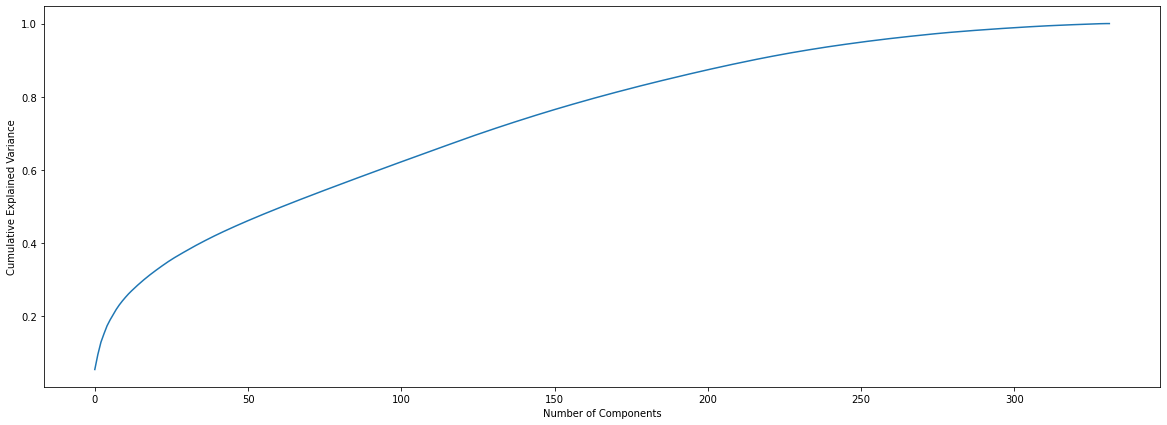

CPU times: user 2min 36s, sys: 13.8 s, total: 2min 50s
Wall time: 56.2 s


In [37]:
%%time
# Lets perform PCA
pca = PCA(random_state=7).fit(azdias)
plt.figure(figsize=(20,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [38]:
# We can see here that first 200 components explain roughly 80% of the variation in the data. Let perform PCA again with 200 components
pca = PCA(n_components=200, random_state=7).fit(azdias)
azdias_pca = pca.transform(azdias)

In [39]:
# Let's look at the weights of these features for each of these principal components
x = ['PC']*200 
y = range(1,201)
principal_components = [i + str(j) for i, j in zip( x, y )]
feature_weights = pd.DataFrame(pca.components_, columns = azdias.columns, index=principal_components)
feature_weights.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_GESAMTTYP,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
PC1,0.053487,-0.074570,0.006289,-0.091302,0.033820,0.059347,-0.129968,0.054378,-0.164191,-0.008585,...,0.007769,-0.000578,-0.000140,0.005565,-0.028346,0.007345,0.023663,0.015001,0.007240,0.082821
PC2,0.085135,0.048557,-0.014309,0.042436,-0.026017,-0.042807,-0.004810,-0.116357,0.030899,0.007095,...,-0.005529,-0.004390,-0.003477,-0.006135,0.019853,-0.008173,-0.024033,-0.015455,-0.000081,0.110111
PC3,0.027510,0.043329,0.197289,0.005468,0.092852,0.022723,-0.034044,-0.001860,-0.011250,0.127835,...,0.004260,0.011137,0.001253,0.007091,-0.067580,0.034012,0.015922,-0.003567,-0.005735,0.035416
PC4,-0.103640,-0.091380,0.018130,0.002945,0.044298,0.078651,0.145759,-0.074947,0.037205,0.031794,...,0.011744,0.012981,0.010190,0.007129,-0.062164,0.023371,0.024857,0.039304,0.011026,-0.137678
PC5,0.096948,-0.086824,-0.011791,-0.015335,0.022147,0.054028,-0.016653,-0.076701,0.022537,0.000993,...,0.008818,0.007668,0.005827,0.006265,-0.040217,0.013427,0.017897,0.019148,0.007770,0.127465


Let's find out most important features for some of these first few components. We will create a function to plot 20 most important features for these principal components

In [40]:
def important_features(pc, draw_plot=True):
    '''
    This function plots top 20 important features of a principal component.
    
    input: principal component name i.e. PC1, PC2 etc.
    
    output: None
    '''
    order_index = feature_weights.loc[pc].abs().sort_values(ascending=False).index
    pc_feature_weights = feature_weights.loc[pc][order_index][0:20].sort_values()
    if draw_plot:
        plt.figure(figsize=(20,7))
        pc_feature_weights.plot(kind='bar');    
        plt.title('Important Features for ' + pc)
        plt.ylabel('Feature Weight')
        plt.show()
    
    return pc_feature_weights

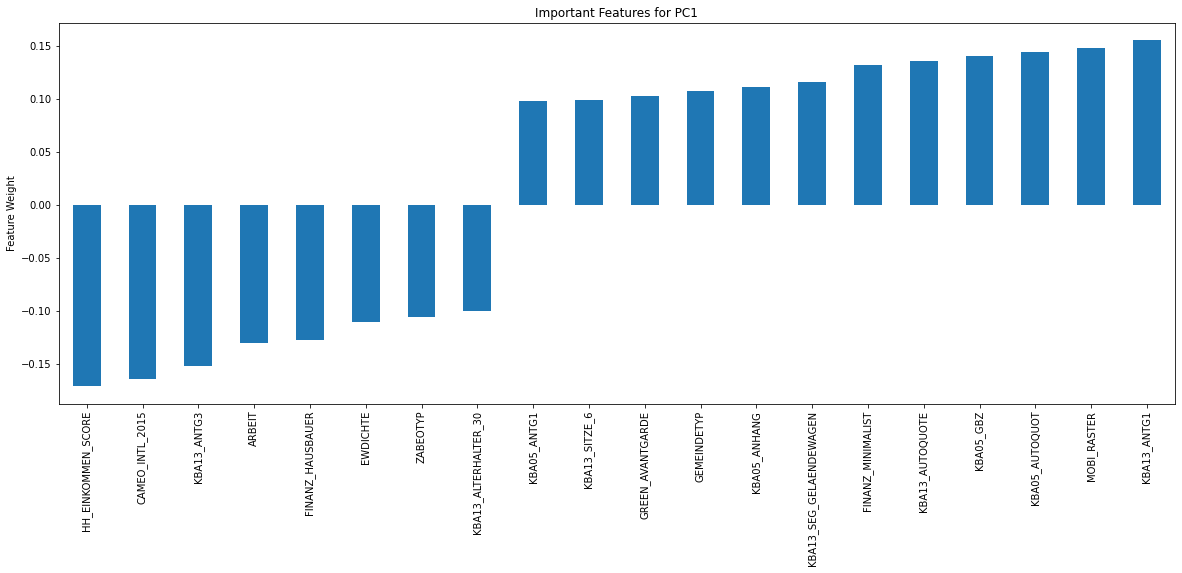

In [41]:
_ = important_features('PC1')

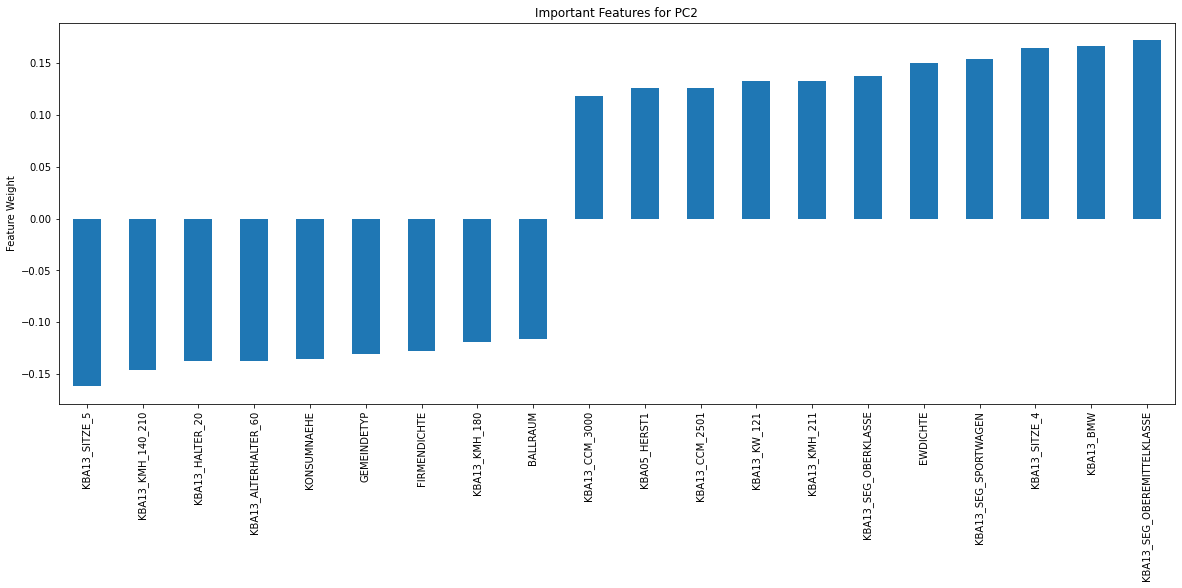

In [42]:
_ = important_features('PC2')

# K-Means Clustering
We will be using MiniBatchKMeans for clustering to speedup processing. The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm. (from sklearn documentation)

CPU times: user 4min 47s, sys: 2min 1s, total: 6min 49s
Wall time: 2min 48s


Text(0, 0.5, 'SSE')

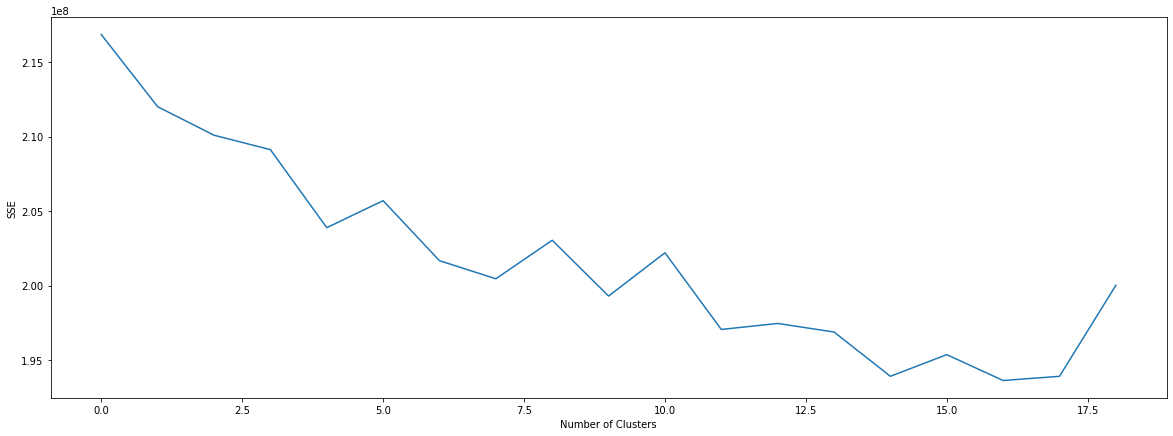

In [43]:
%%time
scores = []
for k in range(2,21):
    scores.append(MiniBatchKMeans(k, random_state=7).fit(azdias_pca).score(azdias_pca))

plt.figure(figsize=(20,7))    
plt.plot(np.abs(scores))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

There is not a significant improvement after 12 clusters. Let's refit and get cluster labels for these data points

In [44]:
kmeans = MiniBatchKMeans(12, random_state=7).fit(azdias_pca)
azdias_labels = kmeans.predict(azdias_pca)

In [45]:
#Let's transform customer data and get the cluster labels
customers_pca = pca.transform(customers)
customers_labels = kmeans.predict(customers_pca)

# Analysis of Customer and general population Clusters

In [46]:
# Calculate customer and general population count percentages in each of the clusters
unique_azdias_labels, azdias_counts = np.unique(azdias_labels, return_counts=True)
unique_customers_labels, customers_counts = np.unique(customers_labels, return_counts=True)

customers_counts_percentage = customers_counts/customers_pca.shape[0]
azdias_counts_percentage = azdias_counts/azdias_pca.shape[0]

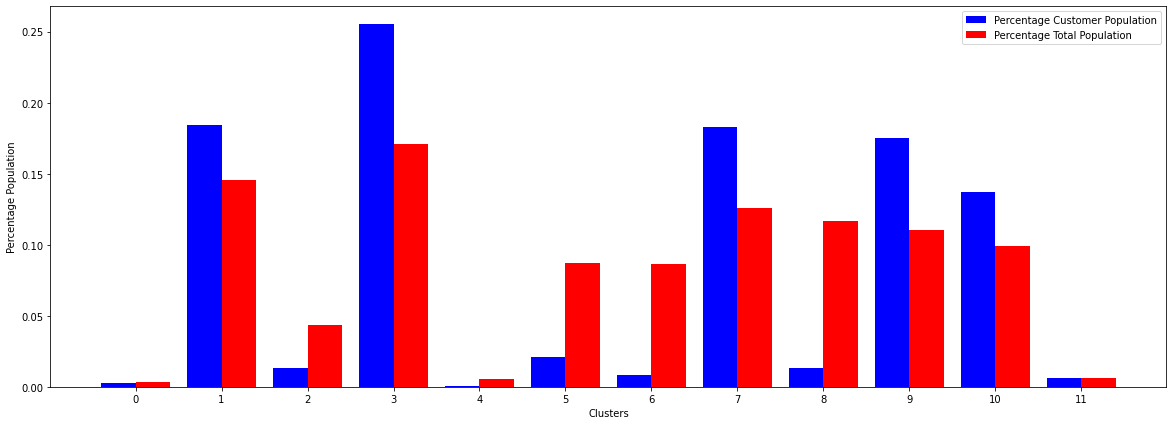

In [47]:
# Plot Customer and population percentage for each of the clusters

number_of_clusters = 12
index = np.arange(number_of_clusters)
width = 0.4
plt.figure(figsize=(20,7))
b1 = plt.bar(x= index, height = customers_counts_percentage, color='blue', label= 'Percentage Customer Population', width= width)
b2 = plt.bar(x= index+width, height = azdias_counts_percentage, color='red',  label='Percentage Total Population', width = width)
plt.xticks(index + width/2, index)
plt.legend(loc='best')
plt.xlabel('Clusters')
plt.ylabel('Percentage Population')
plt.show()

We see in this plot that cluster 3 has the highest percentage of total customers. Clusters 1, 7, 9 and 10 are some of the other clusters with significant customer concentration. 

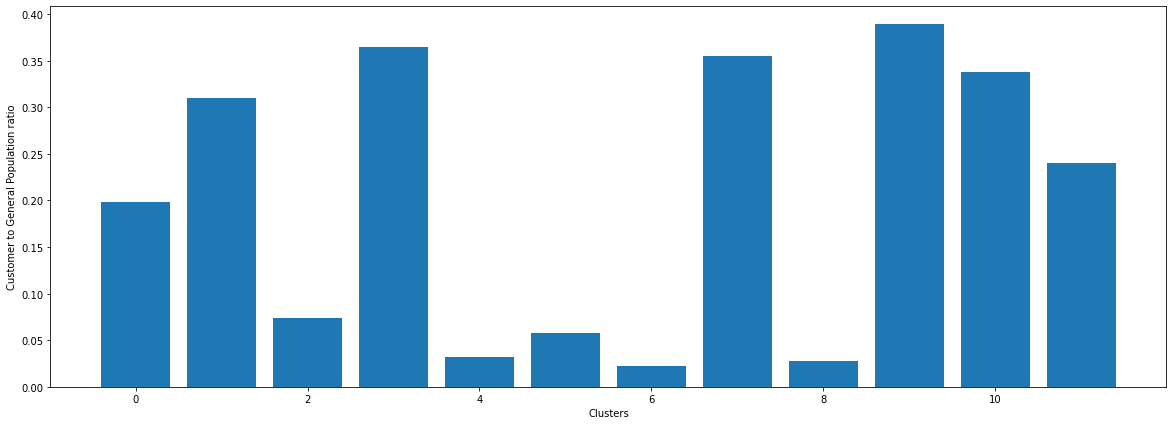

In [48]:
# Calculate customer to general population ratio in each of the clusters

customer_general_population_ratio = customers_counts/azdias_counts
plt.figure(figsize=(20,7))
plt.bar(x=index, height=customer_general_population_ratio)
plt.xlabel('Clusters')
plt.ylabel('Customer to General Population ratio')
plt.show()

This plot suggests that cluster 9 has highest customer to population ratio of roughly 40%. I would recommend targeting population in clusters 3, 7, 9 and 10. At the same it would be advisable to see why customer to population ratio is so low in some of the clusters like 4, 6 and 8. Maybe, a special offer might entice people to become customers.

Let's see if we can map these clusters to the original features we got with the dataset. It is one of the challenges with PCA where you work with transformed features instead of the original ones.

In [49]:
# We will create a function to determine which top 10 features are important in a cluster
def cluster_features(n):
    '''
    This function determines which features are important in a cluster.
    First we find principal components with larger weight and
    then we get important features of these principal components
    
    Input: Cluster number i.e. 0 - 12
    
    Output: None
    '''
    
    pc_weights = pd.DataFrame(kmeans.cluster_centers_[n], columns=['Weight'], index=principal_components)        
    order_index = pc_weights.abs().sort_values(by='Weight',ascending=False).index   
    print('These are the top 4 principal components by weight in cluster {}' .format(n))
    print(pc_weights.loc[order_index][0:4])
    pcs = list(pc_weights.loc[order_index][0:4].index)
    most_important_features = pd.Series(dtype='float')
    for pc in pcs:
        most_important_features = most_important_features.append(important_features(pc, False))
    order = most_important_features.abs().sort_values(ascending=False).index
    most_important_features = most_important_features.loc[order][0:10].to_frame()    
    most_important_features.reset_index(inplace=True)
    most_important_features.columns = ['Feature', 'Weight']
    most_important_features = most_important_features.merge(azdias_features, left_on='Feature', right_on='Attribute', how='left')
    most_important_features = most_important_features[['Feature', 'Weight','Description']].drop_duplicates()
    pd.options.display.width = 1000
    pd.options.display.max_colwidth = 100
    print('\n These are some of the important features in this cluster')
    print(most_important_features)

In [50]:
# Let's look at important features in cluster 9 which has high customer to population ratio
cluster_features(9)

These are the top 4 principal components by weight in cluster 9
       Weight
PC2  4.623554
PC1  3.058266
PC3 -1.715304
PC4  1.120980

 These are some of the important features in this cluster
                 Feature    Weight                                                                Description
0              CJT_TYP_1  0.242114                                                                        NaN
1              CJT_TYP_6 -0.221066                                                                        NaN
2   ALTERSKATEGORIE_GROB -0.216327                               age classification through prename analysis 
7       FINANZ_VORSORGER -0.214246                                            financial typology: be prepared
12             CJT_TYP_3 -0.214120                                                                        NaN
13         SEMIO_PFLICHT  0.204303  affinity indicating in what way the person is dutyfull traditional minded
20           SEMIO_TRADV  0.203461   

Now we have a list of important features in cluster 9 which has the highest customer to population ratio. We can see that age, financial preparedness, interest in investments etc. are important  features in this cluster. Now let's look at the value of some of these features in the cluster

In [51]:
# We will be looking at feature values in cluster 9 but same can be done for other clusters as well
cluster9_indexes = np.where(customers_labels==9)

def feature_value_distribution(feature):
    feature_df = azdias_features[azdias_features.Attribute==feature][['Value','Meaning']]
    value_counts = customers_clean.iloc[cluster9_indexes][feature].value_counts().to_frame().reset_index()    
    value_counts.columns = ['Value','Counts']
    df = value_counts.merge(feature_df, left_on='Value', right_on='Value', how='inner')
    #customers_clean.iloc[cluster10_indexes].ALTERSKATEGORIE_GROB.value_counts().bar()
    plt.figure(figsize=(20,7))
    df = df[['Meaning','Counts']]
    plt.bar(df.Meaning, df.Counts)
    plt.title(feature)
    plt.show()

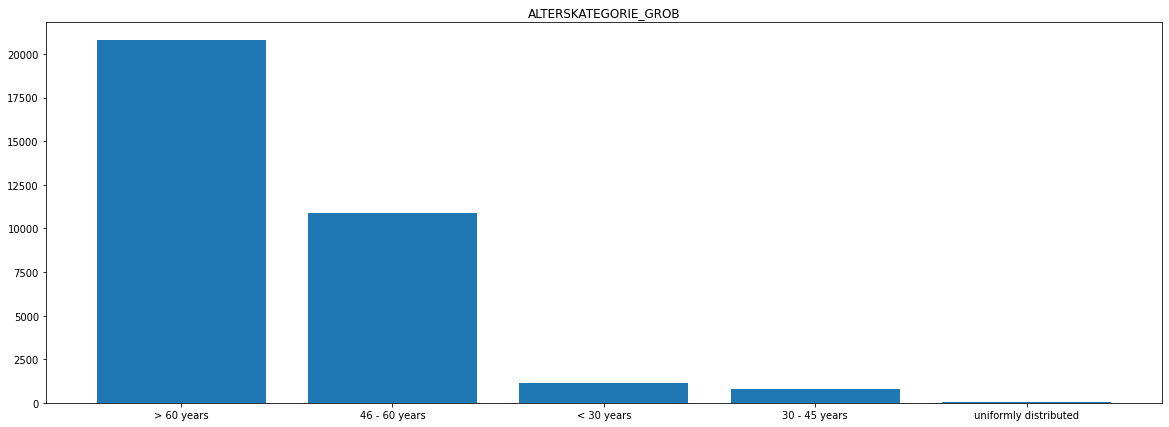

In [52]:
feature_value_distribution('ALTERSKATEGORIE_GROB')

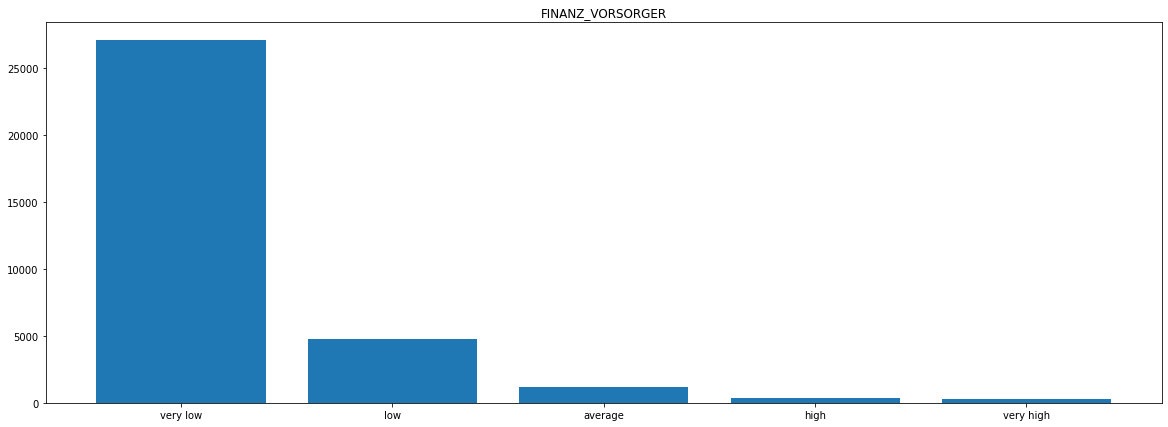

In [53]:
feature_value_distribution('FINANZ_VORSORGER')

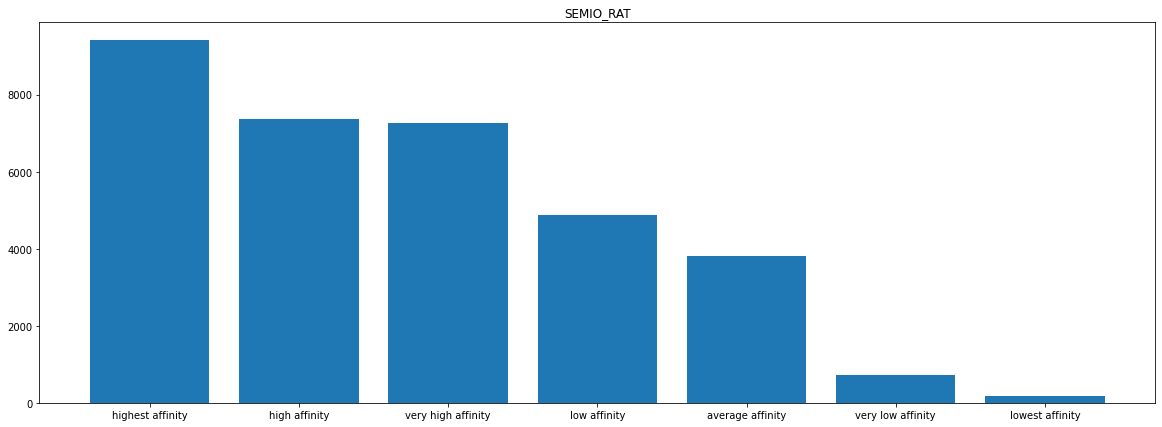

In [54]:
feature_value_distribution('SEMIO_RAT')

We can see from the plots above that most customers in cluster 9 are older than 60 yrs. old. Their financial preparedness appear to be low and have high affinity to rational mind

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [55]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [56]:
#Let's load training dataset
train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
train.head()

/home/sumit/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [57]:
# We have the same warning here that we got earlier in our analysis. Our cleaning function should work just fine. Let's try it out
train = clean_data(train)
train.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_GESAMTTYP,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
0,1763,1.0,8.0,NaN,0.0,1.0,3.0,5.0,34.0,2.0,...,0,0,0,0,1,0,0,0,0,1
1,1771,4.0,13.0,1.0,0.0,2.0,2.0,5.0,32.0,2.0,...,0,1,0,0,0,0,0,0,0,1
2,1776,1.0,9.0,NaN,0.0,NaN,4.0,1.0,14.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,1460,1.0,6.0,4.0,0.0,2.0,4.0,2.0,14.0,2.0,...,0,0,0,0,1,0,0,0,0,1
4,1783,1.0,9.0,NaN,0.0,1.0,3.0,4.0,41.0,6.0,...,0,0,0,0,0,0,0,0,0,1


In [58]:
# Let's separate out predictors and response variables. To keep things consistent with sklearn library we would call the response variable y and the predictors dataset X
y = train.RESPONSE
X = train.drop('RESPONSE', axis=1)

Text(0.5, 1.0, 'Campaign OutCome')

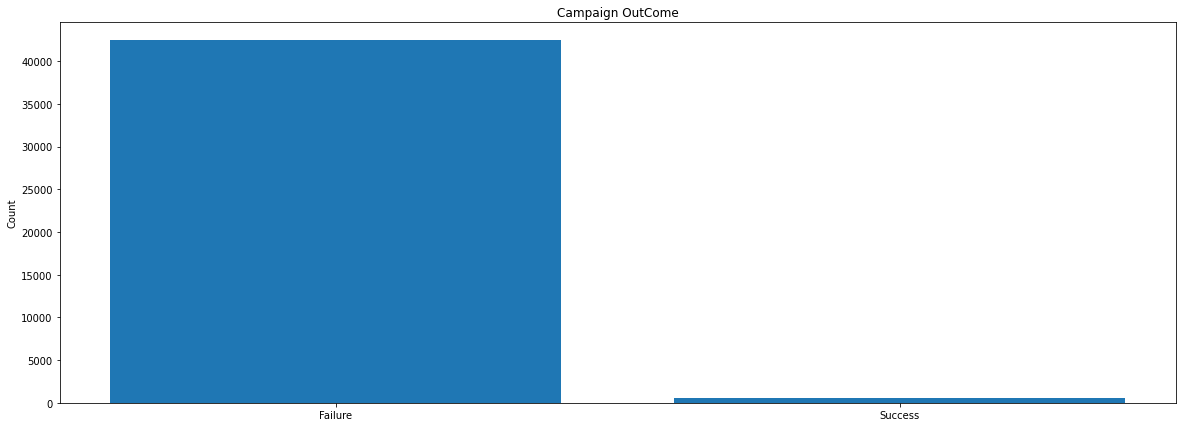

In [59]:
# Let's look at our response variable
plt.figure(figsize=(20,7))
plt.bar(['Failure','Success'],y.value_counts())
plt.ylabel('Count')
plt.title('Campaign OutCome')


Our data set is inbalanced as there is a small number of positive outcomes (customers) and a very large number of negative outcomes (people who were targeted by mailing campaign but did not become customers). Any model would do well predicting a negative outcome since we have so many of those to train on but the real challenge is to predict positive outcome. There are a couple of ways to work with such imbalanced data. We can under or over sample to get a balanced dataset. However, we will use AUROC (Area Under the Receiver Operating Characteristics).

Most classification models calculate a probability for positive or negative outcome. Threshold is 50% by default. So, if calculated probability is more than 0.5 a positive outcome is predicted otheriwse a negative outcome is predicted. AUC/ROC allows us to visualize the model performance at varying thresholds. Higher area under the curve translates to higher performance. Business knowledge is usually needed to choose a threshold. It usually depends on what is more costly to a business: Losing a potential customer or losing money on someone who has low probability of becoming a customer.

My opinion is this case would be that losing a customer is more expensive than to lose money on a mailing campaign for someone who is less likely to become a customer. Meaning, we would prefer false positives over false negatives.

# Impute and Scale

In [60]:
#Impute
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

#Scale
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Modeling
Let's create a function that we can use for different classifiers and use roc_auc score as performance metric with cross validation

In [61]:
scores = []
def roc_auc_classifier(classifier, params_grid={}, X=X, y=y):
    '''
    Check classifier performance with GridSearchCV
    
    Input: Classifier, hyper parameters for the classifier, predictor dataset and the response variable
    
    Output: Return the best parameters for a model   
    
    '''    
    gcv = GridSearchCV(classifier, param_grid= params_grid, scoring='roc_auc', cv=3)
    gcv.fit(X, y)
    scores.append([classifier.__class__.__name__, gcv.best_score_])
    
    print(gcv.best_score_)
    
    return(gcv.best_estimator_)

In [62]:
%%time
# Random Forest classifier
rf = RandomForestClassifier(random_state=7)
params_grid = {'max_depth':[5,10],
               'n_estimators':[100, 200]}

roc_auc_classifier(rf, params_grid)

0.6777210026825383
CPU times: user 1min 11s, sys: 150 ms, total: 1min 11s
Wall time: 1min 11s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [63]:
%%time
# Logistic Regression
lr = LogisticRegression(random_state=7, max_iter=1000)
params_grid = {'C':[0.001],
                'solver':['newton-cg', 'lbfgs']}
roc_auc_classifier(lr, params_grid)

0.6125458536656296
CPU times: user 23.8 s, sys: 5.62 s, total: 29.4 s
Wall time: 8.42 s


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
%%time
# AdaBoostClassifier
adb = AdaBoostClassifier(random_state=7)
params_grid = {
               'learning_rate':[0.20, .50, 1],
               'n_estimators':[20, 50, 100]
              }
roc_auc_classifier(adb, params_grid)

0.7599348942814372
CPU times: user 3min 53s, sys: 414 ms, total: 3min 53s
Wall time: 3min 53s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.2,
                   n_estimators=20, random_state=7)

In [65]:
%%time
gbc = GradientBoostingClassifier(random_state=7)
params_grid = {
               'learning_rate':[0.1, 0.5],
               'n_estimators':[100, 200]
              }
roc_auc_classifier(gbc, params_grid)

0.754948105133014
CPU times: user 9min 28s, sys: 656 ms, total: 9min 29s
Wall time: 9min 29s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

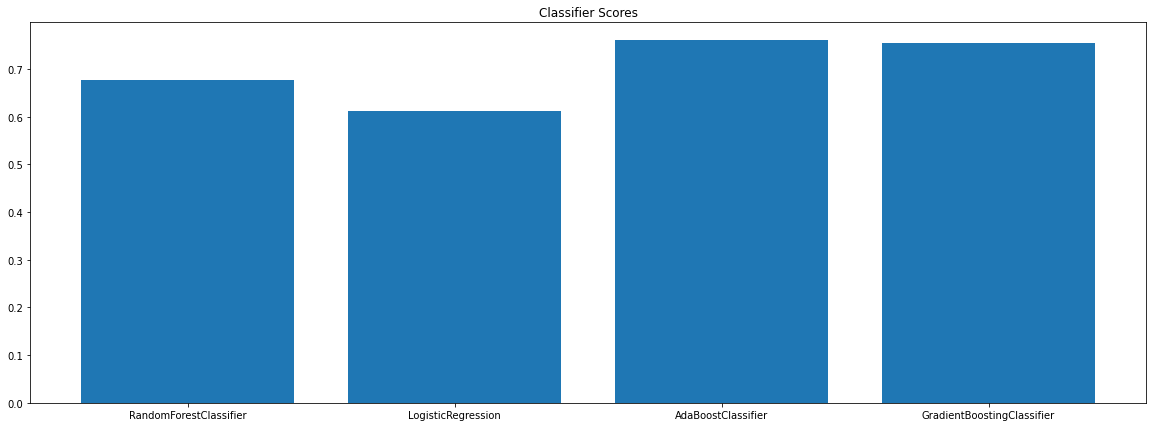

In [66]:
# Plot model and corresponding scores
score = pd.DataFrame(scores, columns=['Model','Score'])
plt.figure(figsize=(20,7))
plt.bar(score.Model, score.Score)
plt.title('Classifier Scores')
plt.show()


# Conclusion
We got the best AUC score of 0.76 using AdaBoostClassifier after some hyper parameter tuning. Learning rate of 0.2 and n_estimators=20 got us to achieve this result. We will be using this model to predict on test data

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [67]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
test.head()

/home/sumit/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [68]:
print(test.shape)

# Save LNR column
test_LNR = test.LNR

(42833, 366)


# Clean, Impute and Scale

In [69]:
test = clean_data(test)

test = imputer.transform(test)

test = scaler.transform(test)

In [70]:
# re-fit with optimized parameters and predict

gcv = GridSearchCV(AdaBoostClassifier(random_state=7), param_grid= {'learning_rate':[0.2], 'n_estimators':[20]}, scoring='roc_auc', cv=3)
gcv.fit(X, y)

predict = gcv.predict_proba(test)

In [71]:
# Write to file
predictions = pd.DataFrame(list(zip(list(test_LNR), predict[:,1])), columns = ['LNR','RESPONSE'])
predictions.to_csv('Arvato.csv', index=False)

Kaggle submission scored 0.79123 on the board. The top score was 0.81063

<img src="kaggle_submission.png">